In [1]:
import pathlib
import pickle

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import hier
import main
import metrics

In [44]:
experiment_root = pathlib.Path(
    '/home/jack/projects/2022-01-hierarchical/experiments/2022-02-28-tiny-incomplete-lr0.1-b256/')

with open('resources/hierarchy/tiny_imagenet_fiveai.csv') as f:
    tree, names = hier.make_hierarchy_from_edges(hier.load_edges(f))

experiment_dirs = {
    'flat': experiment_root / 'complete-flat',
    'hier': experiment_root / 'complete-hier',
    'hxe-0.1': experiment_root / 'complete-hxe-0.1',
    'hxe-0.2': experiment_root / 'complete-hxe-0.2',
    'hxe-0.5': experiment_root / 'complete-hxe-0.5',
}

# with open('resources/hierarchy/tiny_imagenet_fiveai.csv') as f:
#     tree, names = hier.make_hierarchy_from_edges(hier.load_edges(f))
# with open('resources/hierarchy/tiny_imagenet_fiveai_incomplete_subset.txt') as f:
#     name_subset = list(map(str.strip, f.readlines()))

# name_to_node = {name: i for i, name in enumerate(names)}
# node_subset = [name_to_node[name] for name in name_subset]
# tree, _, _ = hier.subtree(tree, node_subset)

# experiment_dirs = {
#     'flat': experiment_root / 'incomplete-flat',
#     'hier': experiment_root / 'incomplete-hier',
# }

In [45]:
def load_results(experiment_dir, epoch):
    epoch_str = '{:04d}'.format(epoch)
    outputs_file = experiment_dir / f'predictions/output-epoch-{epoch_str}.pkl'
    # operating_points_file = experiment_dir / f'predictions/operating-points-epoch-{epoch_str}.pkl'
    full_outputs_file = experiment_dir / f'predictions/full-output-epoch-{epoch_str}.pkl'

    with open(outputs_file, 'rb') as f:
        outputs = pickle.load(f)
    with open(full_outputs_file, 'rb') as f:
        full_outputs = pickle.load(f)

    outputs.update(full_outputs)
    return outputs

In [46]:
outputs = load_results(experiment_dirs['flat'], 100)

In [50]:
# Re-normalize.
# outputs['prob'] = outputs['prob'] / outputs['prob'][:, [0]]

In [51]:
pred_seqs = [main.sorted_above_threshold(p, 0.5) for p in outputs['prob']]
prob_seqs = [outputs['prob'][i, pred_i] for i, pred_i in enumerate(pred_seqs)]

In [52]:
# Truncate at LCA.
find_lca_fn = hier.FindLCA(tree)
lca_seqs = [find_lca_fn(gt, pr) for gt, pr in zip(outputs['gt'], pred_seqs)]
pred_seqs = [hier.truncate_given_lca(gt, pr, lca)
             for gt, pr, lca in zip(outputs['gt'], pred_seqs, lca_seqs)]
# TODO: Remove redundant elements from pred_seqs and scores?
len([pr for pr in pred_seqs if len(set(pr)) != len(pr)]) / len(pred_seqs)

0.0

In [53]:
info_metric = metrics.UniformLeafInfoMetric(tree)
depth_metric = metrics.DepthMetric(tree)
# depth_metric = metrics.LCAMetric(tree, tree.depths() + 1)
metric_fns = {
    'exact': lambda gt, pr: pr == gt,
    'correct': metrics.IsCorrect(tree),
    'info_deficient': info_metric.deficient,
    'info_excess': info_metric.excess,
    'info_recall': info_metric.recall,
    'info_precision': info_metric.precision,
    'info_dist': info_metric.dist,
    'info_lca': info_metric.value_at_lca,
    'info_gt': info_metric.value_at_gt,
    'info_pr': info_metric.value_at_pr,
    'depth_deficient': depth_metric.deficient,
    'depth_excess': depth_metric.excess,
    'depth_recall': depth_metric.recall,
    'depth_precision': depth_metric.precision,
    'depth_dist': depth_metric.dist,
    'depth_lca': depth_metric.value_at_lca,
    'depth_gt': depth_metric.value_at_gt,
    'depth_pr': depth_metric.value_at_pr,
}

In [54]:
metric_seqs = {}
for field in metric_fns:
    metric_fn = metric_fns[field]
    # TODO: Could vectorize if necessary.
    metric_seqs[field] = [metric_fn(gt, pr) for gt, pr in zip(outputs['gt'], pred_seqs)]

/home/jack/projects/2022-01-hierarchical/hier-class/metrics.py:122: RuntimeWarning: invalid value encountered in true_divide
  return self.value[lca] / self.value[pr]


In [55]:
def pool_operating_points(example_scores, example_metrics):
    # Obtain order of scores.
    step_scores = np.concatenate([seq[1:] for seq in example_scores])
    step_order = np.argsort(-step_scores)
    step_scores = step_scores[step_order]
    metric_seqs = {}
    for field in example_metrics:
        # Get metric sequence for each example.
        example_seqs = example_metrics[field]
        example_seqs = [seq.astype(float) for seq in example_seqs]
        total_init = np.sum([seq[0] for seq in example_seqs])
        total_deltas = np.concatenate([np.diff(seq) for seq in example_seqs])[step_order]
        metric_seqs[field] = total_init + cumsum_with_zero(total_deltas)
    return metric_seqs, step_scores

def cumsum_with_zero(x: np.ndarray, axis: int = 0) -> np.ndarray:
    ndim = x.ndim
    pad_width = [(0, 0)] * ndim
    pad_width[axis] = (1, 0)
    return np.cumsum(np.pad(x, pad_width, 'constant'), axis=axis)

In [56]:
totals, thresholds = pool_operating_points(prob_seqs, metric_seqs)

In [57]:
_, first_index = np.unique(-thresholds, return_index=True)
last_index = np.concatenate([first_index[1:], [len(thresholds)]]) - 1
thresholds = thresholds[last_index]
totals = {k: v[np.concatenate([[0], last_index])] for k, v in totals.items()}

In [58]:
means = {k: v / len(outputs['gt']) for k, v in totals.items()}

In [59]:
means['info_recall'] = means['info_lca'] / means['info_gt']
means['info_precision'] = means['info_lca'] / means['info_pr']

# Add 1 to depth to count root node.
# means['depth_recall'] = (means['depth_lca'] + 1) / (means['depth_gt'] + 1)
# means['depth_precision'] = (means['depth_lca'] + 1) / (means['depth_pr'] + 1)
means['depth_recall'] = means['depth_lca'] / means['depth_gt']
means['depth_precision'] = means['depth_lca'] / means['depth_pr']

/tmp/ipykernel_1698238/80535701.py:2: RuntimeWarning: invalid value encountered in true_divide
  means['info_precision'] = means['info_lca'] / means['info_pr']
/tmp/ipykernel_1698238/80535701.py:8: RuntimeWarning: invalid value encountered in true_divide
  means['depth_precision'] = means['depth_lca'] / means['depth_pr']


In [60]:
def plot_metrics(x, y):
    plt.plot(means[x], means[y])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.grid()
    plt.show()

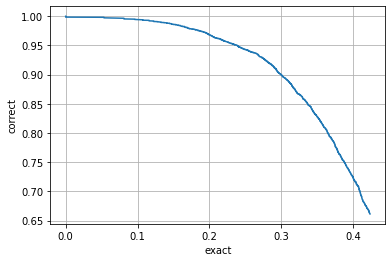

In [61]:
plot_metrics('exact', 'correct')

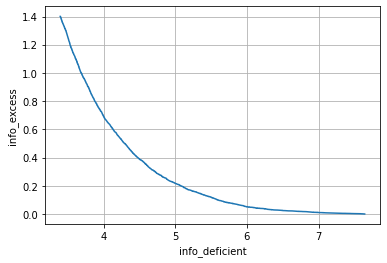

In [62]:
plot_metrics('info_deficient', 'info_excess')

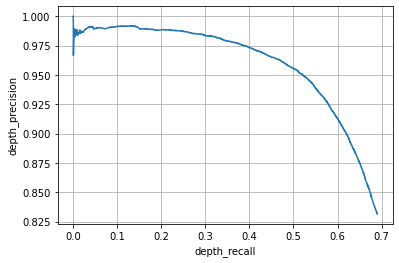

In [63]:
plot_metrics('depth_recall', 'depth_precision')

In [64]:
def add_metrics(means):
    means = dict(means)
    means['info_recall'] = means['info_lca'] / means['info_gt']
    means['info_precision'] = means['info_lca'] / means['info_pr']
    means['depth_recall'] = means['depth_lca'] / means['depth_gt']
    means['depth_precision'] = means['depth_lca'] / means['depth_pr']
    return means

In [65]:
def predict_and_evaluate(outputs):
    depth = tree.depths()
    pred = {}
    pred['leaf'] = main.argmax_leaf(tree, outputs['prob'], axis=-1)
    pred['majority'] = main.argmax_value_with_threshold(tree, depth, outputs['prob'], 0.5, axis=-1)

    # Truncate at LCA.
    pred = {
        method: hier.truncate_given_lca(
            outputs['gt'], pred[method],
            hier.lca(tree, outputs['gt'], pred[method]))
        for method in pred
    }
    means = {
        method: add_metrics({
            field: np.mean(fn(outputs['gt'], pred[method]))
            for field, fn in metric_fns.items()
        })
        for method in pred
    }
    return means

In [66]:
predict_and_evaluate(outputs)

{'leaf': {'exact': 0.4952,
  'correct': 0.4952,
  'info_deficient': 2.9378142474613047,
  'info_excess': 2.9378142474613047,
  'info_recall': 0.6156633282306838,
  'info_precision': 0.6156633282306838,
  'info_dist': 5.875628494922609,
  'info_lca': 4.70604194231342,
  'info_gt': 7.643856189774724,
  'info_pr': 7.643856189774724,
  'depth_deficient': 2.1863,
  'depth_excess': 2.1652,
  'depth_recall': 0.7267125,
  'depth_precision': 0.7286342728947599,
  'depth_dist': 4.3515,
  'depth_lca': 5.8137,
  'depth_gt': 8.0,
  'depth_pr': 7.9789},
 'majority': {'exact': 0.4236,
  'correct': 0.6612,
  'info_deficient': 3.396057752942103,
  'info_excess': 1.4015095426632929,
  'info_recall': 0.5557140704079375,
  'info_precision': 0.7519148278426219,
  'info_dist': 4.797567295605397,
  'info_lca': 4.24779843683262,
  'info_gt': 7.643856189774724,
  'info_pr': 5.649307979495914,
  'depth_deficient': 2.4798,
  'depth_excess': 1.1189,
  'depth_recall': 0.690025,
  'depth_precision': 0.8314681206790

In [67]:
def construct_curves(outputs, min_threshold=0.5):
    pred_seqs = [main.sorted_above_threshold(p, min_threshold) for p in outputs['prob']]
    prob_seqs = [outputs['prob'][i, pred_i] for i, pred_i in enumerate(pred_seqs)]

    # Truncate at LCA.
    find_lca_fn = hier.FindLCA(tree)
    lca_seqs = [find_lca_fn(gt, pr) for gt, pr in zip(outputs['gt'], pred_seqs)]
    pred_seqs = [hier.truncate_given_lca(gt, pr, lca)
                 for gt, pr, lca in zip(outputs['gt'], pred_seqs, lca_seqs)]
    
    metric_seqs = {
        field: [fn(gt, pr) for gt, pr in zip(outputs['gt'], pred_seqs)]
        for field, fn in metric_fns.items()
    }

    totals, thresholds = pool_operating_points(prob_seqs, metric_seqs)

    _, first_index = np.unique(-thresholds, return_index=True)
    last_index = np.concatenate([first_index[1:], [len(thresholds)]]) - 1
    thresholds = thresholds[last_index]
    totals = {k: v[np.concatenate([[0], last_index + 1])] for k, v in totals.items()}

    means = {k: v / len(outputs['gt']) for k, v in totals.items()}
    means = add_metrics(means)
    return means, thresholds

In [68]:
epoch = 100
min_threshold = 0.5
# min_threshold = 0.05
curves = {}
points = {}
for name, experiment_dir in experiment_dirs.items():
    outputs = load_results(experiment_dir, epoch)
    curves[name], _ = construct_curves(outputs, min_threshold)
    points[name] = predict_and_evaluate(outputs)

/home/jack/projects/2022-01-hierarchical/hier-class/metrics.py:122: RuntimeWarning: invalid value encountered in true_divide
  return self.value[lca] / self.value[pr]
/tmp/ipykernel_1698238/491779403.py:4: RuntimeWarning: invalid value encountered in true_divide
  means['info_precision'] = means['info_lca'] / means['info_pr']
/tmp/ipykernel_1698238/491779403.py:6: RuntimeWarning: invalid value encountered in true_divide
  means['depth_precision'] = means['depth_lca'] / means['depth_pr']


In [69]:
MARKERS = {
    'leaf': 's',
    'majority': 'o',
}

COLORS = dict(zip(experiment_dirs,
                  map(matplotlib.cm.get_cmap('tab10'),
                      range(len(experiment_dirs)))))

In [70]:
def plot_metrics(x, y):
    for name in curves:
        plt.plot(curves[name][x], curves[name][y], label=name,
                 color=COLORS[name])
        for method in ['majority', 'leaf']:
            plt.plot(points[name][method][x], points[name][method][y],
                     marker=MARKERS[method], color=COLORS[name])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.grid()
    plt.legend()
    plt.show()

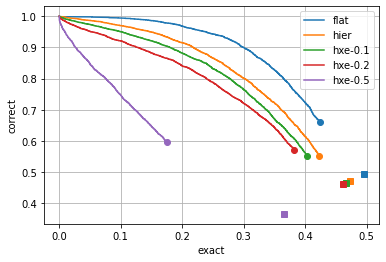

In [71]:
plot_metrics('exact', 'correct')

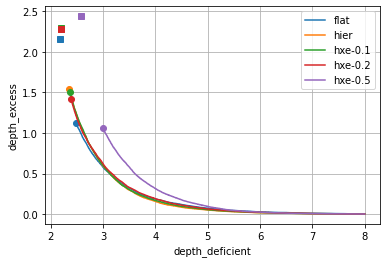

In [72]:
plot_metrics('depth_deficient', 'depth_excess')

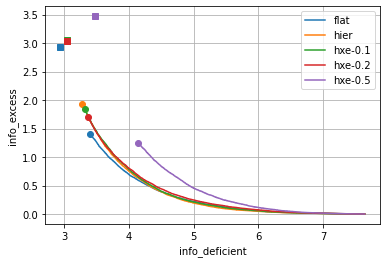

In [73]:
plot_metrics('info_deficient', 'info_excess')

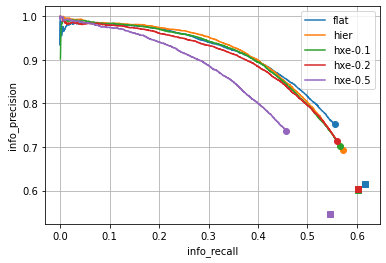

In [74]:
plot_metrics('info_recall', 'info_precision')

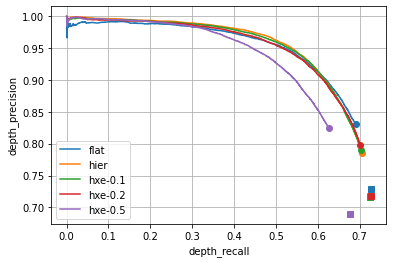

In [75]:
plot_metrics('depth_recall', 'depth_precision')

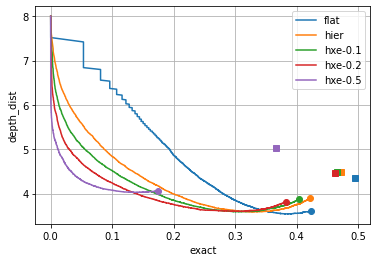

In [76]:
plot_metrics('exact', 'depth_dist')

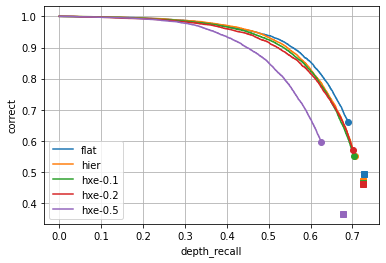

In [80]:
plot_metrics('depth_recall', 'correct')

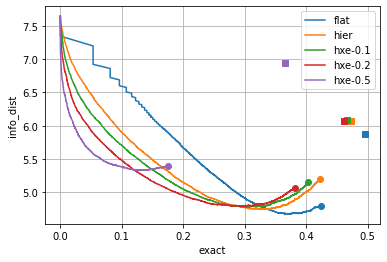

In [77]:
plot_metrics('exact', 'info_dist')